In [1]:
import sys
sys.path.append('../')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.read_data import read_timeseries_s22, read_weather_s22
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import h5py


%matplotlib inline

set_mpl()

matplotlib settings set
matplotlib settings set


In [3]:
weather = read_weather_s22()

energy = read_timeseries_s22()


READ FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/2018_weather.hdf5
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/2019_weather.hdf5
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/2020_weather.hdf5
READ FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/
DATA LOADED FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/. 
 Houses number removed: 24, 25. 
 Houses with PV: ['13', '15', '26', '33'] 
 HOUSEHOLD and HEATPUMP energy consumption are separated. 
 Resolution: 60min 
 Years: 2018
READ FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/
DATA LOADED FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/. 
 Houses number removed: 24, 25. 
 Houses with PV: ['13', '15', '26', '33'] 
 HOUSEHOLD and HEATPUMP energy consumption are separated. 

In [4]:
heat_cols = [col for col in energy.columns if 'P_HEAT' in col]
home_cols = [col for col in energy.columns if 'P_HOME' in col]
tot_cols = [col for col in energy.columns if 'P_TOT' in col]


#exclude May-June 2019 data for home # 34
energy.loc['2019-05-01':'2019-06-01', ['P_HOME_34',	'P_HEAT_34',	'P_TOT_34',]] = np.nan
#eclude may 15-18 2018 since for all homes there is a strange interpolation due to the gap
energy.loc['2018-05-15':'2018-05-18', :] = np.nan


energy['homes_num'] = energy[tot_cols].count(axis=1)

energy['P_HEAT_avg'] = energy[heat_cols].sum(axis=1)/energy['homes_num']
energy['P_HOME_avg'] = energy[home_cols].sum(axis=1)/energy['homes_num']
energy['P_TOT_avg'] = energy[tot_cols].sum(axis=1)/energy['homes_num']

#drop data before 2018-05-04
energy = energy.query('index > "2018-05-04"')


In [5]:

for df in [energy, weather]:
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear

    df['season'] = df['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
    df['workday'] = df['weekday'].apply(lambda x: 'workday' if x in [0, 1, 2, 3, 4] else 'weekend')


# Missing data and imputing

<AxesSubplot: title={'left': 'Proportion of missing values in total energy consumption'}>

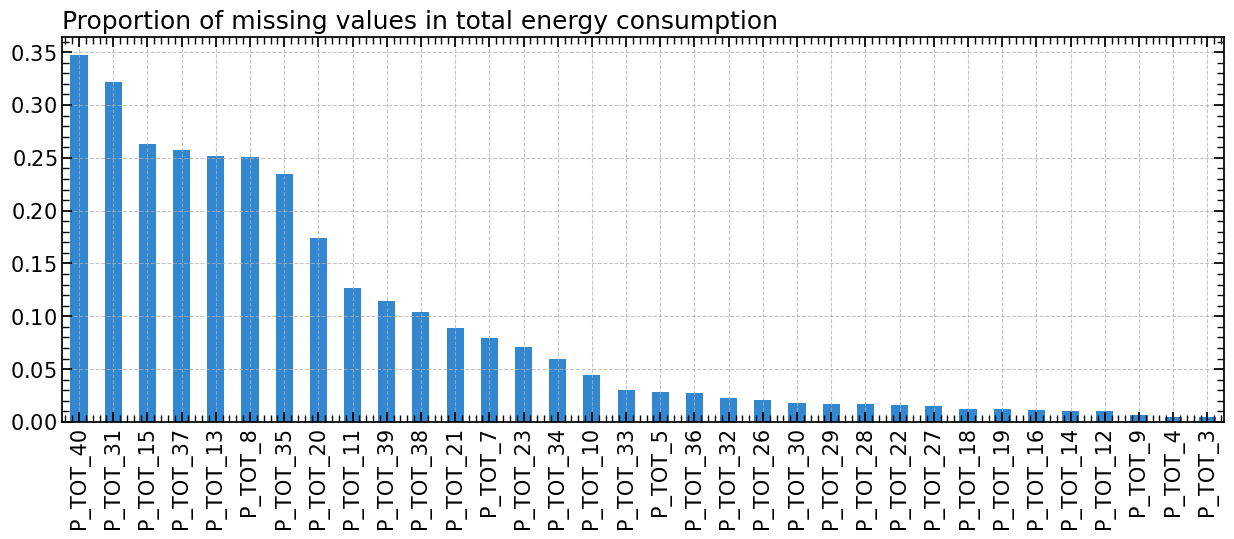

In [6]:
energy[tot_cols].isna().mean(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5), title='Proportion of missing values in total energy consumption')


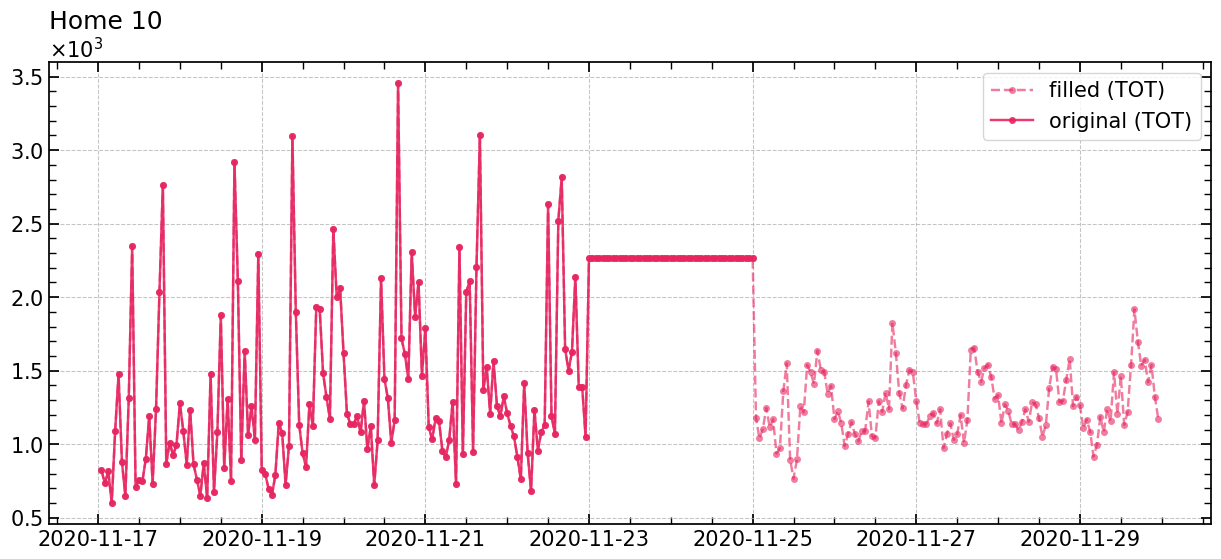

In [27]:
energy_filled = energy.copy()


# interpolate missing values for each home by month, weekday, hour mean 
for heat_col, home_col, tot_col in zip(heat_cols, home_cols, tot_cols):
    energy_filled.fillna({heat_col: energy.groupby(by = ['month', 'weekday', 'hour'])[heat_col].transform('median')}, inplace=True)
    energy_filled.fillna({home_col: energy.groupby(by = ['month', 'weekday', 'hour'])[home_col].transform('median')}, inplace=True)
    energy_filled.fillna({tot_col: energy.groupby(by = ['month', 'weekday', 'hour'])[tot_col].transform('median')}, inplace=True)



%matplotlib inline
home_to_plot = 10
fig,  ax =  plt.subplots( figsize = (15,6))
#focus on may 2019
query = 'index > "2020-11-17" and index < "2020-11-30"'
ax.plot(energy_filled.query(query).index, energy_filled.query(query)[f'P_TOT_{home_to_plot}'], 'C1o--', alpha=0.6, label = 'filled (TOT)')
ax.plot(energy.query(query).index, energy.query(query)[f'P_TOT_{home_to_plot}'], 'C1o-', alpha=0.9, label = 'original (TOT)')

#ax.plot(energy_filled.query(query).index, energy_filled.query(query)[f'P_HEAT_{home_to_plot}'], 'bo--', alpha=0.6, label = 'filled (HEAT)')
#ax.plot(energy.query(query).index, energy.query(query)[f'P_HEAT_{home_to_plot}'], 'bo-', alpha=0.9, label = 'original (HEAT)')
#
#ax.plot(energy_filled.query(query).index, energy_filled.query(query)[f'P_HOME_{home_to_plot}'], 'go--', alpha=0.6, label = 'filled (HOME)')
#ax.plot(energy.query(query).index, energy.query(query)[f'P_HOME_{home_to_plot}'], 'go-', alpha=0.9, label = 'original (HOME)')
ax.set_title(f'Home {home_to_plot}')
ax.legend()


# Load curves exploration

P_HOME_3    P_HEAT_3     P_TOT_3    P_HOME_4  \
season workday hour                                                   
autumn weekend 0     139.184716   57.876758  197.061474  254.723145   
               1     153.372890  147.250672  300.623562  253.216310   
               2     162.969258  179.340132  342.309391  249.709397   
               3     132.985924  286.464029  419.449954  260.653112   
               4     150.140875  292.709058  442.849933  277.548637   
...                         ...         ...         ...         ...   
winter workday 19    252.030001  469.173688  721.203689  499.475248   
               20    226.600887  309.172592  535.773479  427.076335   
               21    190.481593  213.433474  403.915066  388.973170   
               22    159.798874  191.688397  351.487271  341.976854   
               23    147.467738   87.112724  234.580462  281.078931   

                        P_HEAT_4      P_TOT_4    P_HOME_5     P_HEAT_5  \
season workday hour                                                      
autumn weekend 0      381.687872   636.411017  231.384222   732.962973   
               1      314.876423   568.092733  216.847644   670.076839   
               2      303.926127   553.635523  203.845100   663.218085   
               3      329.350956   590.004068  208.029143   650.925795   
               4      322.353252   599.901889  202.882321   639.286185   
...                          ...          ...         ...          ...   
winter workday 19    1293.391971  1792.867219  531.637909  1037.886774   
               20    1214.833361  1641.909697  456.846905  1034.573769   
               21    1221.203854  1610.177025  391.639857   974.234114   
               22    1271.327626  1613.304480  344.641536   992.074970   
               23    1279.561604  1560.640535  315.234792  1020.184770   

                         P_TOT_5    P_HOME_7    P_HEAT_7      P_TOT_7  \
season workday hour                                                     
autumn weekend 0      964.190690  164.585771  259.325916   425.934587   
               1      887.274878  160.671456  222.270707   393.381438   
               2      867.071708  169.560926  335.476505   506.922657   
               3      858.999211  159.279937  556.791378   718.914929   
               4      842.406679  190.460379  557.001296   748.277843   
...                          ...         ...         ...          ...   
winter workday 19    1569.524684  621.100289  641.231660  1262.331949   
               20    1491.420674  469.933930  616.025408  1085.959338   
               21    1365.873971  423.657574  601.598896  1025.256470   
               22    1336.716506  294.159669  562.154503   856.314172   
               23    1335.419562  179.858607  567.250670   747.109277   

                       P_HOME_8    P_HEAT_8      P_TOT_8    P_HOME_9  \
season workday hour                                                    
autumn weekend 0     137.343058  509.141299   650.546831  259.469516   
               1     122.479714  384.756148   507.647409  233.751463   
               2     116.932508  473.582567   598.979909  215.175852   
               3     119.928950  445.709154   568.917067  220.677185   
               4     125.404125  503.572681   626.584508  262.639200   
...                         ...         ...          ...         ...   
winter workday 19    509.718693  885.498826  1399.124659  695.595052   
               20    450.131848  803.154941  1272.781854  543.397138   
               21    333.065874  807.545717  1137.208371  494.886503   
               22    197.355393  860.814991  1062.161720  369.497380   
               23    146.264330  799.951904   945.812296  277.473570   

                        P_HEAT_9      P_TOT_9   P_HOME_10   P_HEAT_10  \
season workday hour                                                     
autumn weekend 0      841.558074  1101.027590  480.428200  918.149236   
               1      782.6924

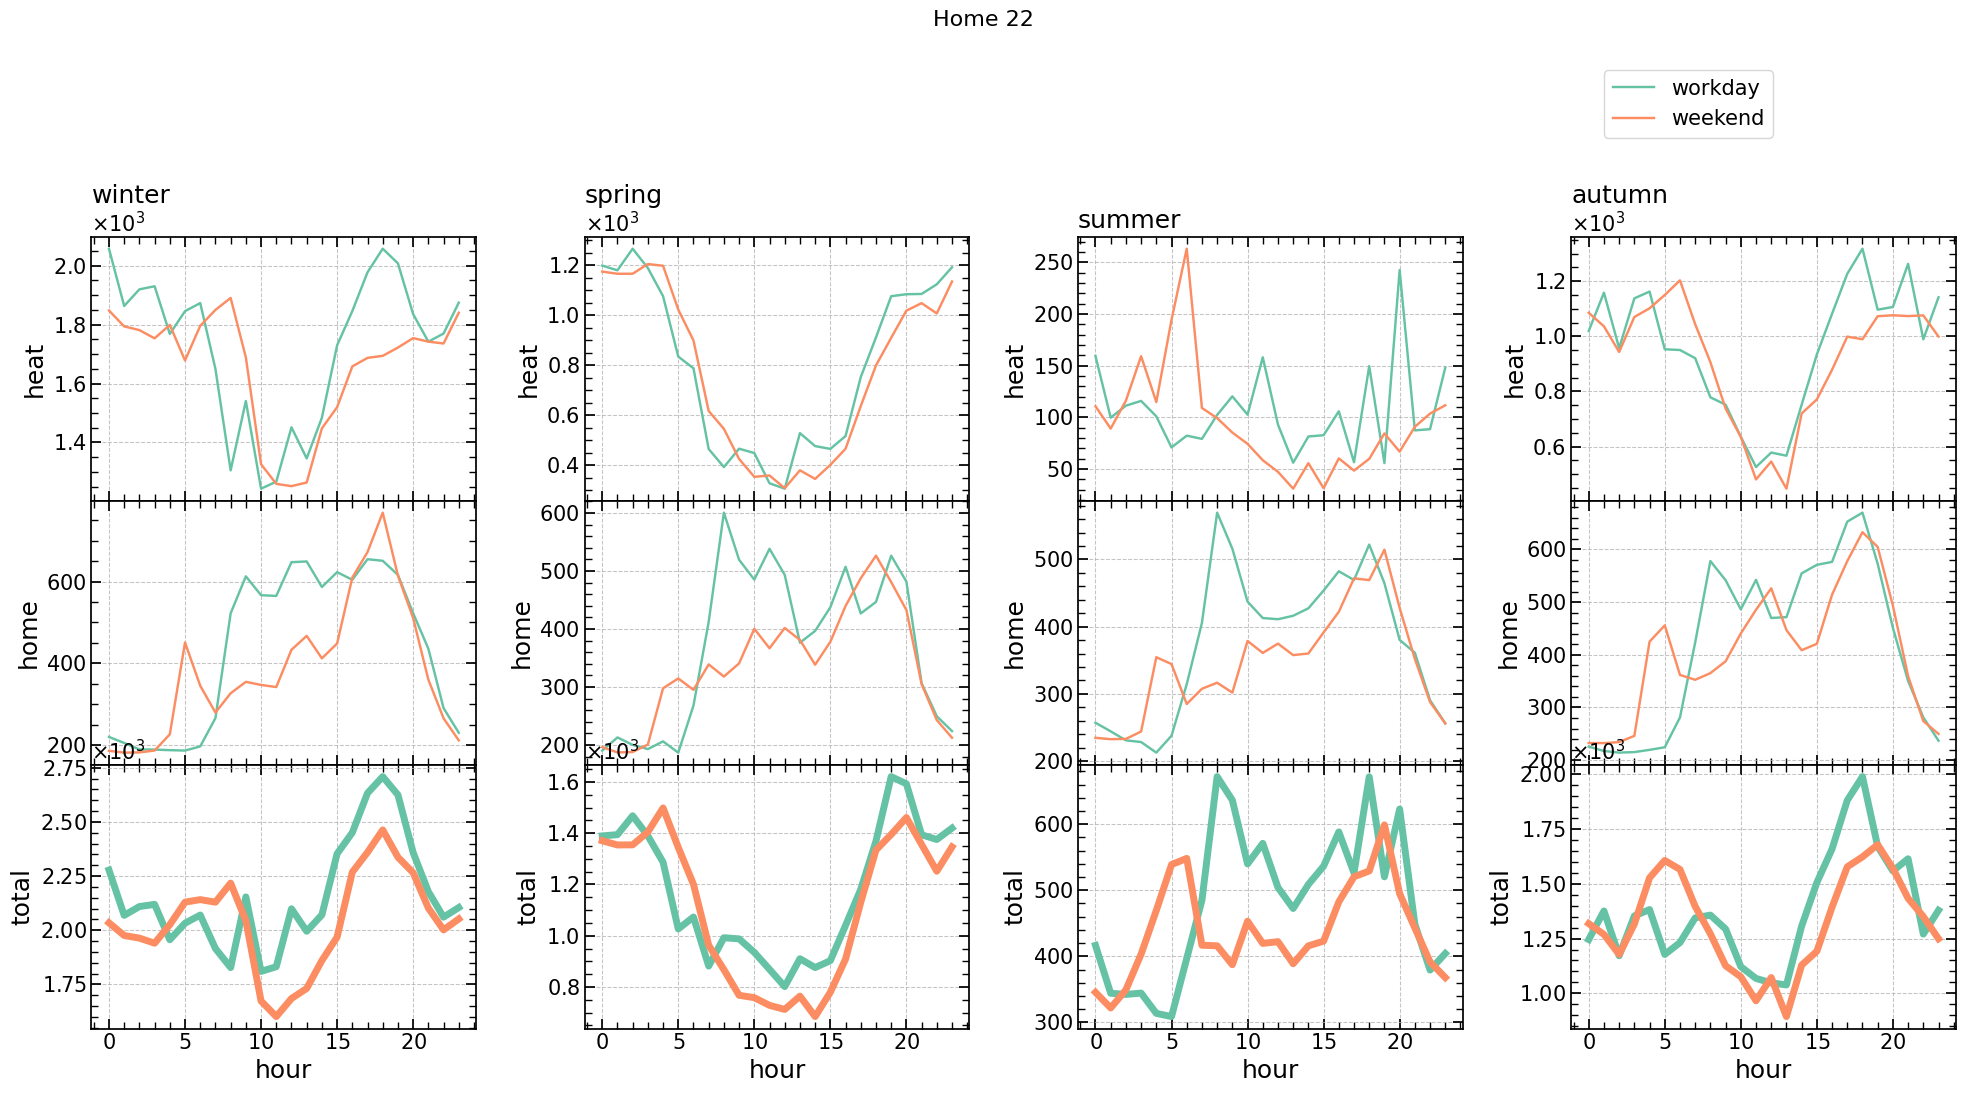

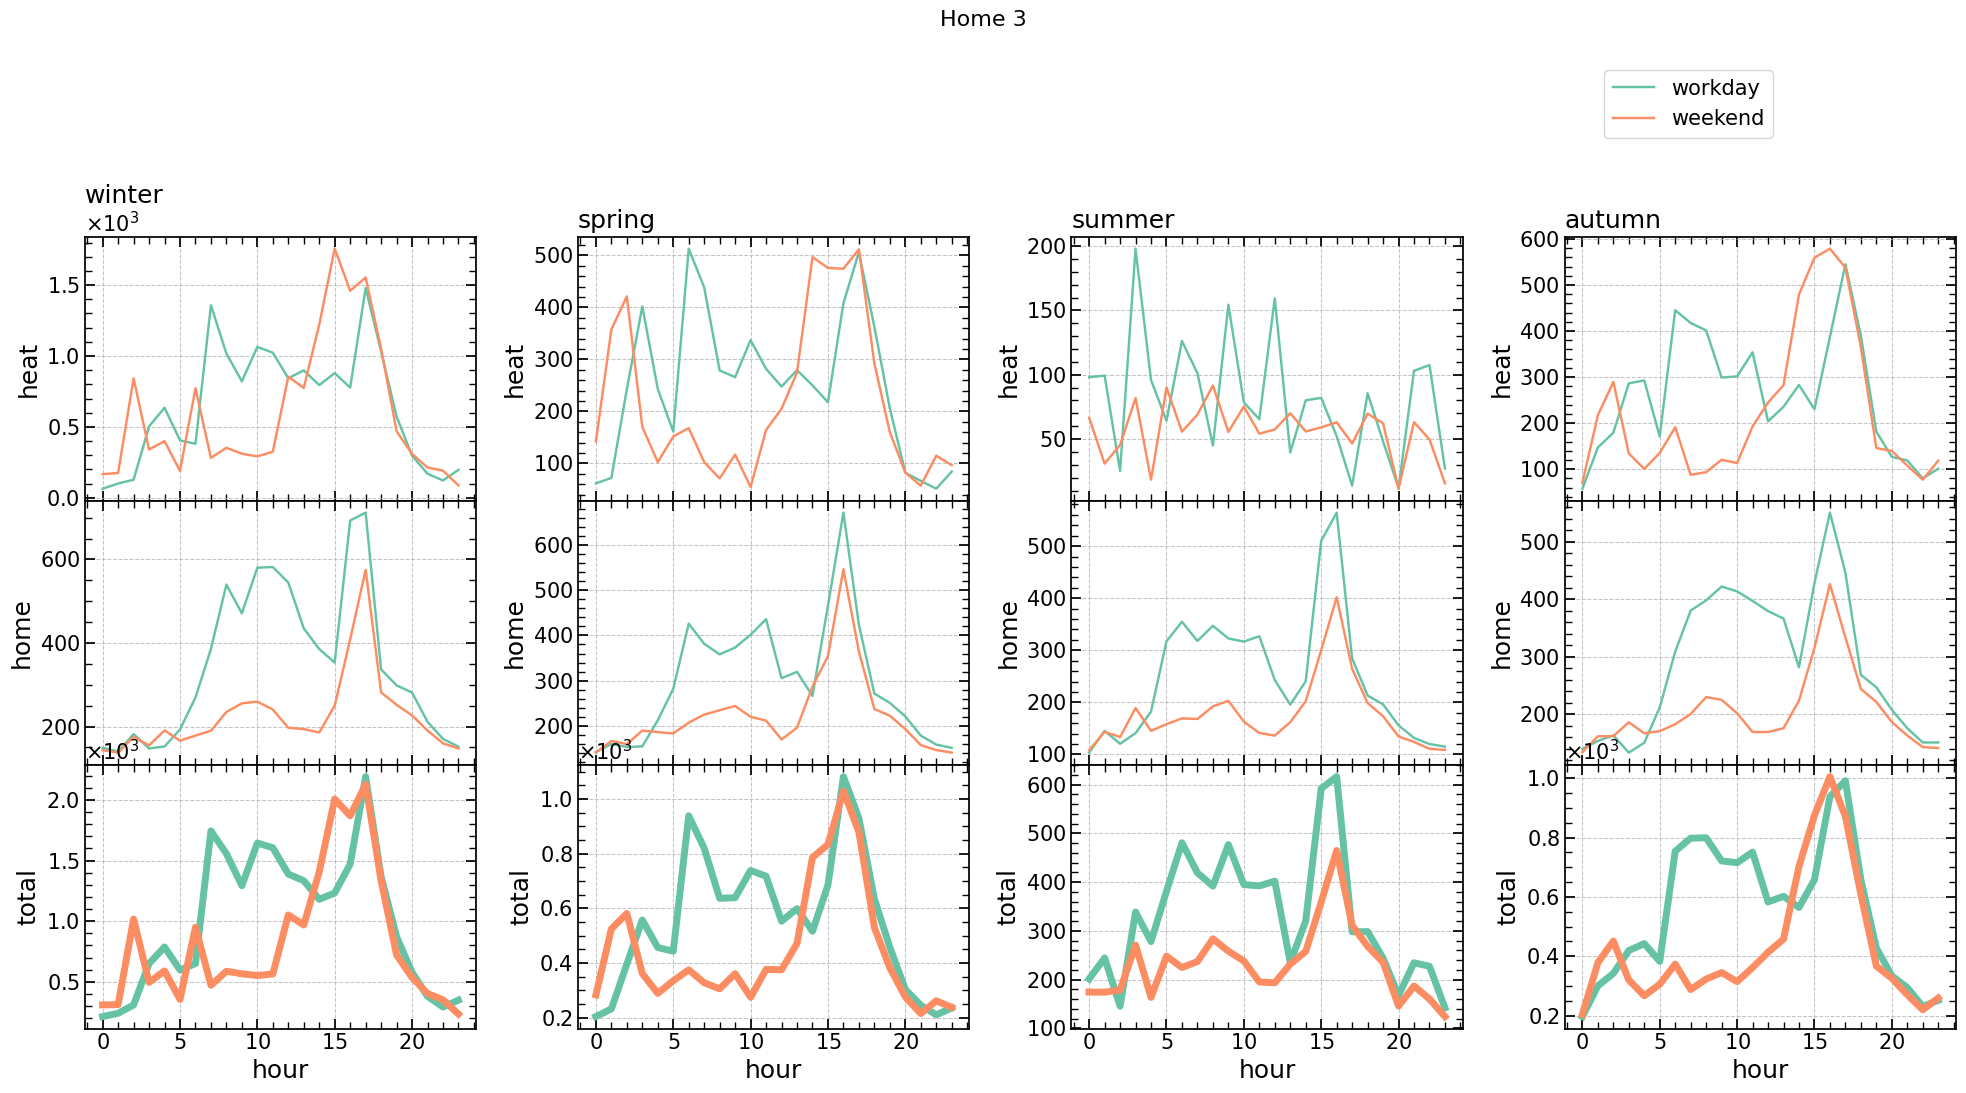

In [29]:
agg = energy_filled.groupby(['season', 'workday',  'hour']).agg('mean')
display(agg)

#homes_to_plot = ['22', '16', '3', '4']
homes_to_plot = ['22','3']

for home in homes_to_plot:
    agg_tmp = agg[[f'P_HEAT_{home}', f'P_HOME_{home}', f'P_TOT_{home}']]
    agg_tmp.columns = ['heat', 'home', 'total']
    #display(agg_tmp)
    fig, axs =  plt.subplots(nrows=3, ncols = 4, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': None}, figsize = (20,10))
    axs = axs.flatten()

    #plot heat energy for top row with different columns for season and different lines for workday/weekend
    for i, season in enumerate(['winter', 'spring', 'summer', 'autumn']):
        sns.lineplot(data=agg_tmp.query('season==@season'), x='hour', y='heat', hue='workday', ax = axs[i], palette='Set2')    
        sns.lineplot(data=agg_tmp.query('season==@season'), x='hour', y='home', hue='workday', ax = axs[i+4], palette='Set2')
        sns.lineplot(data=agg_tmp.query('season==@season'), x='hour', y='total', hue='workday', ax = axs[i+4+4], palette='Set2', lw = 5)
        axs[i].set_title(season)
        axs[i].legend().remove()
        axs[i+4].legend().remove()
        axs[i+4+4].legend().remove()

    fig.suptitle(f'Home {home}', fontsize=16, y = 1.1)
    fig.legend(labels=['workday', 'weekend'], loc='upper right', bbox_to_anchor=(0.9, 1.05))
    fig.tight_layout()

# Spectrogram exploration

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_55864/203133890.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.pcolormesh(Sxx_df.index, Sxx_df.columns, np.log10(Sxx_df.T), shading='gouraud', cmap='PiYG')


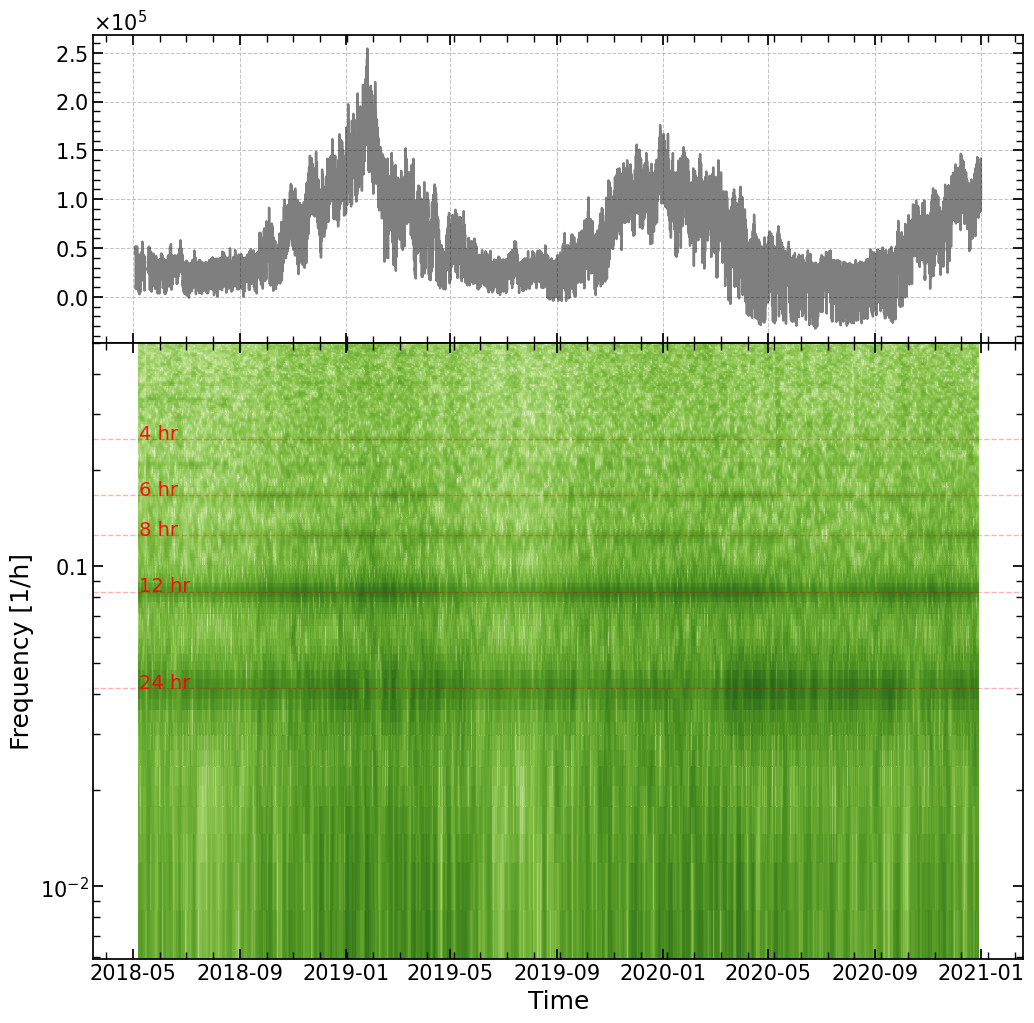

In [33]:
from scipy import signal
ts = energy_filled[['P_substation']].fillna(method='ffill')

spectra = signal.spectrogram(ts.iloc[:, 0], nperseg=24*7, noverlap = 24*7-1, scaling='spectrum', mode='psd', detrend='linear', window = 'tukey')
f, t, Sxx = spectra

Sxx_df = pd.DataFrame(Sxx, index = f, columns = t)
Sxx_df = Sxx_df.T
Sxx_df.index = pd.Series(Sxx_df.index).apply(lambda x: ts.index[int(x)]).values

Sxx_df.drop(columns = 0, inplace = True)


# Sxx_df_rebinned = Sxx_df.T.copy()
# f_bins = np.logspace(np.log10(0.01), np.log10(0.5), 14)
# f_bins_mid = (f_bins[1:] + f_bins[:-1])/2
# Sxx_df_rebinned  = Sxx_df_rebinned.groupby(pd.cut(Sxx_df_rebinned.index, bins = f_bins)).mean()
# Sxx_df_rebinned.index = f_bins_mid
# Sxx_df_rebinned = Sxx_df_rebinned.T


#%matplotlib auto
#%matplotlib inline

fig, [ax1, ax2] =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [1,2]}, figsize = (12,12))


ax2.pcolormesh(Sxx_df.index, Sxx_df.columns, np.log10(Sxx_df.T), shading='gouraud', cmap='PiYG')

for period_hr in [24, 12, 8, 4, 6]:
    ax2.axhline(1/period_hr, color='r', linestyle='--', lw=1, alpha = 0.3, label = f'{period_hr} hr')
    ax2.text(Sxx_df.index[0], 1/period_hr, f'{period_hr} hr', color='r', fontsize=14, alpha = 0.9)
ax2.set_yscale('log')

ax1.plot(ts.index, ts.iloc[:, 0], 'k-', alpha=0.5, label = 'original')

plt.ylabel('Frequency [1/h]')
plt.xlabel('Time')
plt.show()



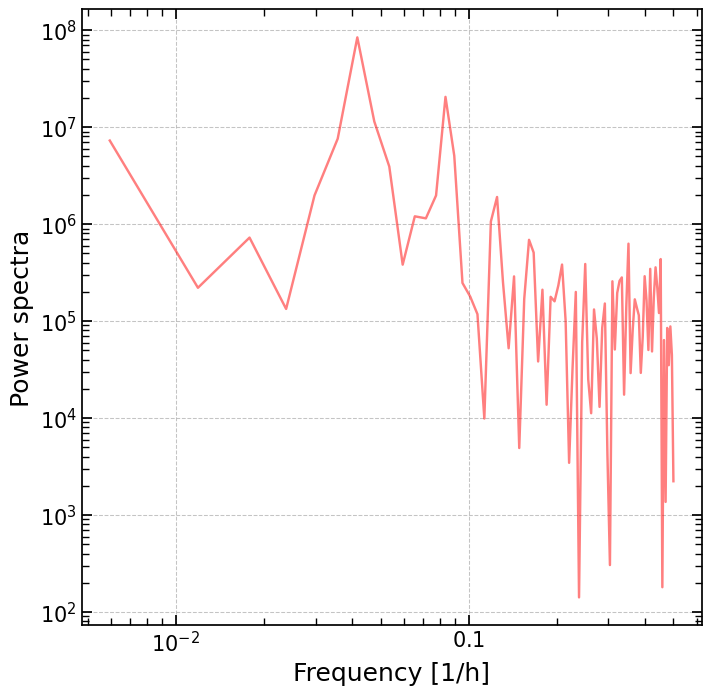

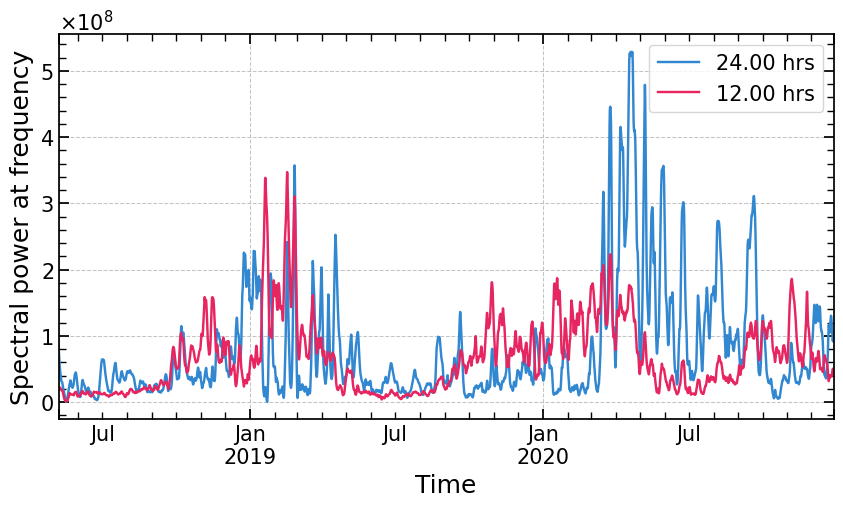

In [34]:
%matplotlib inline

fig,  ax =  plt.subplots( figsize = (8,8))

ax.loglog(Sxx_df.iloc[0].index, Sxx_df.iloc[0].values, 'r-', alpha=0.5, label = 'original')
ax.set(xlabel='Frequency [1/h]', ylabel='Power spectra')

fig,  ax =  plt.subplots( figsize = (10,5))
Sxx_df.iloc[:, [6, 13] ].plot(ax=ax )
ax.set(xlabel='Time', ylabel='Spectral power at frequency')
freqs = Sxx_df.columns[[6, 13]].values
ax.legend([f'{1/freqs[0]:.2f} hrs', f'{1/freqs[1]:.2f} hrs'])

# Random forest forecast for substaring

In [14]:
data = energy_filled[['P_substation', 'hour','weekday','month','year','doy','season','workday']].fillna(method='ffill')

Sxx_df_tmp = Sxx_df.copy()
Sxx_df_tmp.columns = [f'f_{i}' for i,x in enumerate(Sxx_df.columns, 1)]
Sxx_df_tmp = Sxx_df_tmp[['f_5', 'f_12']]
data = data.merge(Sxx_df_tmp, left_index=True, right_index=True)

#features_cols are all the columns that are not time related

features_cols = ['P_substation'] + [x for x in Sxx_df_tmp.columns]

max_lag = 5

lags_cols = []

for lag in range(1, max_lag+1):
    for col in features_cols:
        tmp = data[col].shift(lag)
        tmp.name = f'{col}_lag_{lag}'
        lags_cols.append(tmp)

data = data.merge(pd.concat(lags_cols, axis=1), left_index=True, right_index=True)

data = data.dropna()

freq_cols = [x for x in data.columns if 'f_' in x]


data = data.drop(columns = ['year', 'doy',	'season',])
#data = data.drop(columns = freq_cols)

data['workday'] = data['workday'].apply(lambda x: 1 if x=='workday' else 0)





data.head(10)

,P_substation,hour,weekday,month,workday,f_5,f_12,P_substation_lag_1,f_5_lag_1,f_12_lag_1,P_substation_lag_2,f_5_lag_2,f_12_lag_2,P_substation_lag_3,f_5_lag_3,f_12_lag_3,P_substation_lag_4,f_5_lag_4,f_12_lag_4,P_substation_lag_5,f_5_lag_5,f_12_lag_5
2018-05-07 18:00:00,33894.757590,18,0,5,1,1.465636e+06,957798.198353,37408.175418,1.591592e+06,1.016219e+06,40854.622201,1.709054e+06,1.063863e+06,20111.497325,1.817473e+06,1.099914e+06,11676.343030,1.905978e+06,1.126185e+06,7277.265544,1.974331e+06,1.145682e+06
2018-05-07 19:00:00,43344.952086,19,0,5,1,1.339599e+06,890345.086922,33894.757590,1.465636e+06,9.577982e+05,37408.175418,1.591592e+06,1.016219e+06,40854.622201,1.709054e+06,1.063863e+06,20111.497325,1.817473e+06,1.099914e+06,11676.343030,1.905978e+06,1.126185e+06
2018-05-07 20:00:00,32788.103328,20,0,5,1,1.213590e+06,816137.613717,43344.952086,1.339599e+06,8.903451e+05,33894.757590,1.465636e+06,9.577982e+05,37408.175418,1.591592e+06,1.016219e+06,40854.622201,1.709054e+06,1.063863e+06,20111.497325,1.817473e+06,1.099914e+06
2018-05-07 21:00:00,31827.541520,21,0,5,1,1.090628e+06,736977.101589,32788.103328,1.213590e+06,8.161376e+05,43344.952086,1.339599e+06,8.903451e+05,33894.757590,1.465636e+06,9.577982e+05,37408.175418,1.591592e+06,1.016219e+06,40854.622201,1.709054e+06,1.063863e+06
2018-05-07 22:00:00,28980.712321,22,0,5,1,9.679634e+05,654137.739273,31827.541520,1.090628e+06,7.369771e+05,32788.103328,1.213590e+06,8.161376e+05,43344.952086,1.339599e+06,8.903451e+05,33894.757590,1.465636e+06,9.577982e+05,37408.175418,1.591592e+06,1.016219e+06
2018-05-07 23:00:00,29203.750052,23,0,5,1,8.476303e+05,568729.946334,28980.712321,9.679634e+05,6.541377e+05,31827.541520,1.090628e+06,7.369771e+05,32788.103328,1.213590e+06,8.161376e+05,43344.952086,1.339599e+06,8.903451e+05,33894.757590,1.465636e+06,9.577982e+05
2018-05-08 00:00:00,31123.646658,0,1,5,1,7.342206e+05,482687.680752,29203.750052,8.476303e+05,5.687299e+05,28980.712321,9.679634e+05,6.541377e+05,31827.541520,1.090628e+06,7.369771e+05,32788.103328,1.213590e+06,8.161376e+05,43344.952086,1.339599e+06,8.903451e+05
2018-05-08 01:00:00,30538.610444,1,1,5,1,6.231375e+05,398043.792780,31123.646658,7.342206e+05,4.826877e+05,29203.750052,8.476303e+05,5.687299e+05,28980.712321,9.679634e+05,6.541377e+05,31827.541520,1.090628e+06,7.369771e+05,32788.103328,1.213590e+06,8.161376e+05
2018-05-08 02:00:00,33584.133124,2,1,5,1,5.193021e+05,317336.295158,30538.610444,6.231375e+05,3.980438e+05,31123.646658,7.342206e+05,4.826877e+05,29203.750052,8.476303e+05,5.687299e+05,28980.712321,9.679634e+05,6.541377e+05,31827.541520,1.090628e+06,7.369771e+05
2018-05-08 03:00:00,33183.533301,3,1,5,1,4.287202e+05,243653.826101,33584.133124,5.193021e+05,3.173363e+05,30538.610444,6.231375e+05,3.980438e+05,31123.646658,7.342206e+05,4.826877e+05,29203.750052,8.476303e+05,5.687299e+05,28980.712321,9.679634e+05,6.541377e+05


In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from typing import Tuple

def mape(y_true: np.ndarray, y_pred: np.ndarray)->np.ndarray:
    """
    Calculates the mean absolute percentage error.
    Args:
        y_true (np.ndarray): True values.
        y_pred (np.ndarray): Predicted values.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true))*100



def model_fit(data: pd.DataFrame, model: RandomForestRegressor , target_col: str = 'P_substation', test_size: float = 0.3, visualize: bool = True, diff_frac: float = 0.4)->Tuple[RandomForestRegressor, pd.DateOffset]:
    """
    Fits the model and calculates the MAPE.
    Args:
        data (pd.DataFrame): Dataframe with the target variable.
        model (RandomForestRegressor): Model to fit.
        target_col (str): Name of the target variable.
        test_size (float): Size of the test set.
        visualize (bool): Whether to visualize the results.
        diff_frac (float): Fraction of the data to use as a definition of outliers (for plotting)
    """





    train, test = train_test_split(
            data, shuffle=False, test_size=test_size )

    X_train = train.drop(target_col, axis=1)
    y_train = train[target_col]

    X_test = test.drop(target_col, axis=1)
    y_test = test[target_col]

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_score = mape(y_train, y_train_pred)
    test_score = mape(y_test, y_test_pred)

    print('Train MAPE: {}'.format(train_score))
    print('Test MAPE: {}'.format(test_score))



    train['pred'] = y_train_pred
    train['train'] = True
    test['pred'] = y_test_pred
    test['train'] = False


    df_res = pd.concat([train, test], axis=0)

    df_res['relative_error'] = (df_res['P_substation'] - df_res['pred']) / df_res['pred']

    if visualize:
        plt.figure(figsize=(9, 9))
        plt.plot(df_res.query('train')['P_substation'], df_res.query('train')['pred'], 'o', label='train', alpha = 0.5, color = 'C1')
        plt.plot(df_res.query('not train')['P_substation'], df_res.query('not train')['pred'], 'o', label='test', alpha = 0.5, color = 'C2')

        max_mw, min_mw = df_res['P_substation'].max(), df_res['P_substation'].min()
        ideal_line = np.linspace(min_mw, max_mw, 100)
        ideal_line_14 = ideal_line * (diff_frac + 1)
        ideal_line_06 = ideal_line * (1 - diff_frac)

        plt.plot(ideal_line, ideal_line, 'k:', alpha = 0.5, label = f'ideal +- {diff_frac*100}%')
        plt.plot(ideal_line, ideal_line_14, 'k--', alpha = 0.2)
        plt.plot(ideal_line, ideal_line_06, 'k--', alpha = 0.2)

        plt.xlabel('actual consumption')
        plt.ylabel('predicted consumption')
        plt.xlim(min_mw, max_mw)
        plt.ylim(min_mw, max_mw)
        
        plt.legend()
        plt.show()


        plt.figure(figsize=(10, 5))
        plt.plot(df_res.query('train')['P_substation'], label='train', alpha = 0.5, color = 'C1')
        plt.plot(df_res.query('train')['pred'], label='train pred', alpha = 0.5, color = 'C1', linestyle = '--')

        plt.plot(df_res.query('not train')['P_substation'], label='test', alpha = 0.5, color = 'C2')
        plt.plot(df_res.query('not train')['pred'], label='test pred', alpha = 0.5, color = 'C2', linestyle = '--')

        plt.xlabel('time')
        plt.ylabel('consumption')
        plt.legend()
        plt.title('Actual and predicted values')
        plt.xticks(rotation=45)
        plt.show()


        #plot last week of train
        plt.figure(figsize=(10, 5))
        plt.plot(df_res.query('train').tail(7*24)['P_substation'], label='train', alpha = 0.5, color = 'C1')
        plt.plot(df_res.query('train').tail(7*24)['pred'], label='train pred', alpha = 0.5, color = 'C0', linestyle = '--')

        plt.xlabel('time')
        plt.ylabel('consumption')
        plt.legend()
        plt.title('Last week of train')
        plt.xticks(rotation=45)


        #plot last week of test
        plt.figure(figsize=(10, 5))
        plt.plot(df_res.query('not train').tail(7*24)['P_substation'], label='test', alpha = 0.5, color = 'C2')
        plt.plot(df_res.query('not train').tail(7*24)['pred'], label='test pred', alpha = 0.5, color = 'C3', linestyle = '--')

        plt.xlabel('time')
        plt.ylabel('consumption')
        plt.legend()
        plt.title('Last week of test')
        plt.xticks(rotation=45)


        plt.show()



    return model, df_res


default_model = RandomForestRegressor(n_estimators=700, max_depth=6, n_jobs=-1,bootstrap = False)

Train MAPE: 0.16558506655124702
Test MAPE: 0.8800759940986939


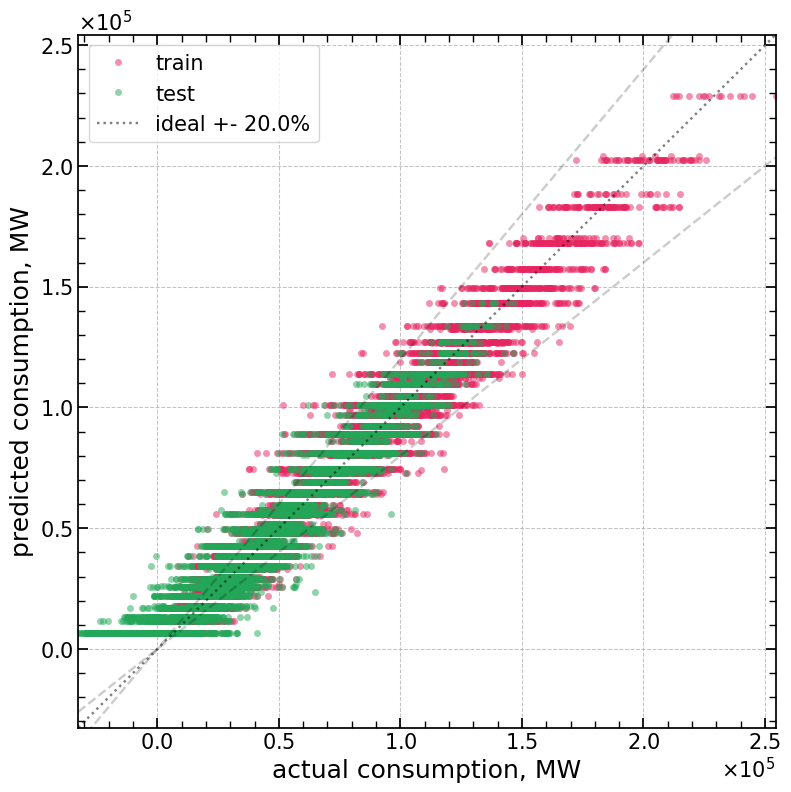

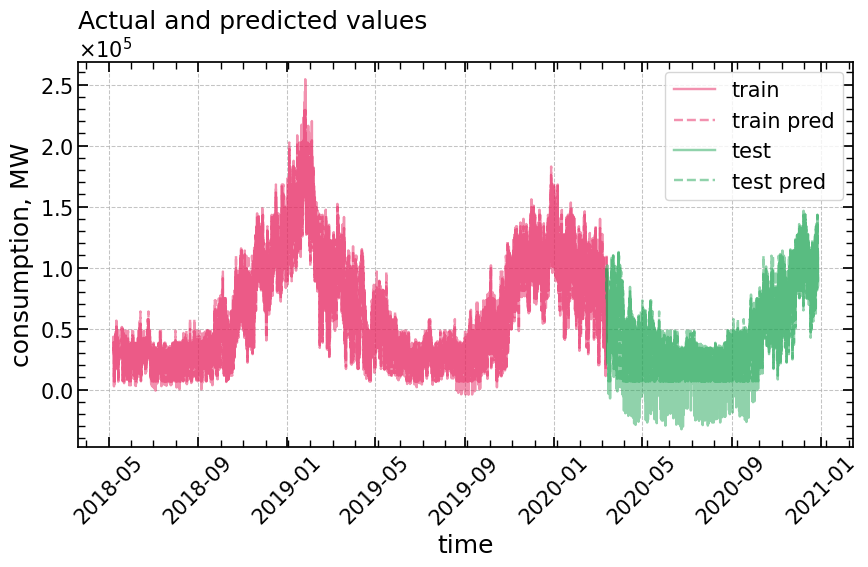

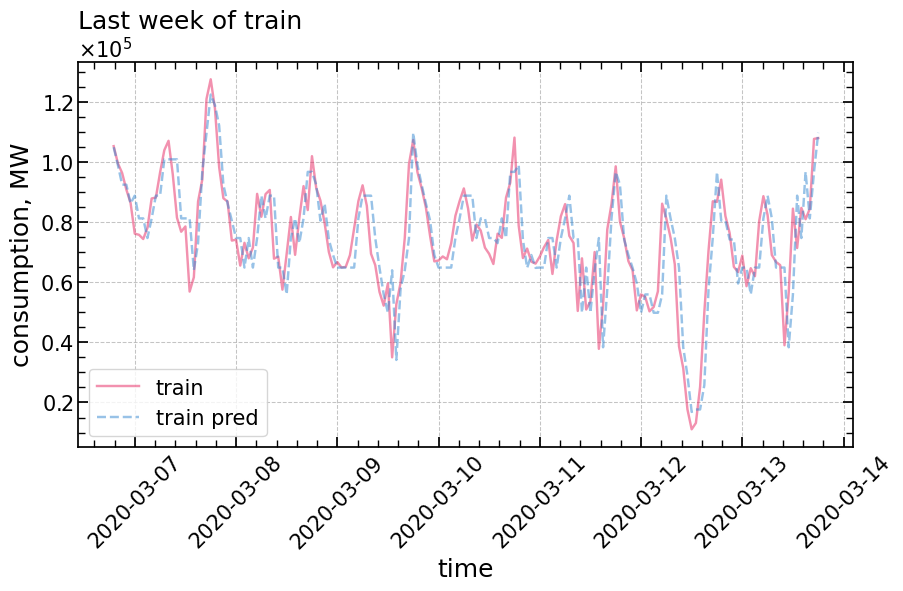

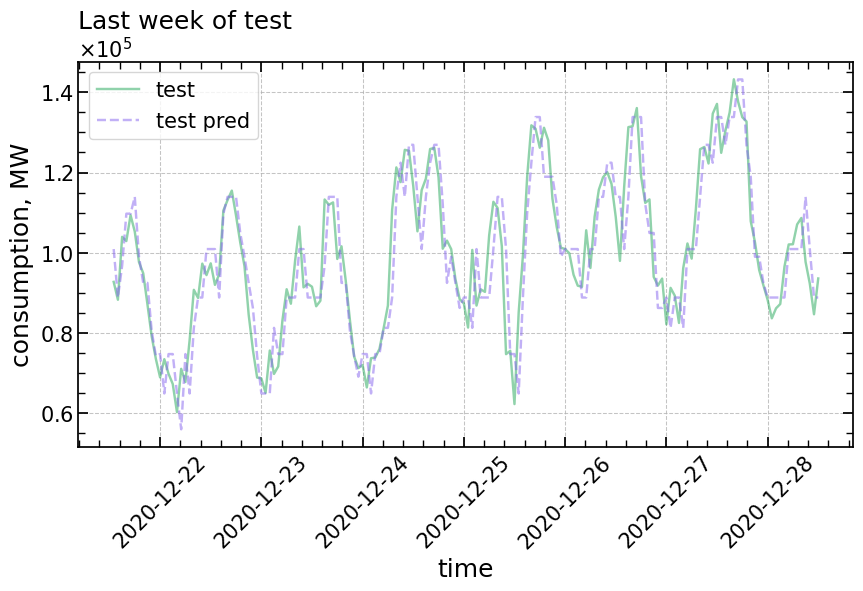

: 

In [68]:
model, df_fit = model_fit(data, default_model,  test_size=0.3, visualize=True, diff_frac = 0.2)